In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import imp
import sys
import scipy
import pickle as plk
import importlib.util
from numpy.lib.scimath import sqrt as csqrt
from IPython.display import display, Math, clear_output
from scipy.signal import find_peaks

###############################################################
#LINUX PATH

# sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
# import lumapi
# sys.path.append(os.path.dirname('/media/leonardo/datam02/Ring Resonator - Leonardo Pessôa/Ring-Resonator/Tutorial/')) #Current directory

###############################################################
#WINDOWS PATH

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/Leo/Documents/Facul/Capacitação/GitHub/90--optical-hybrid'))
spec_win.loader.exec_module(lumapi)


def imbalance(n,p):
    return 10*np.log10(p/n)

def CMRR(n,p):
    return 20*np.log10(abs((p-n)/(p+n)))

def functionstapers(lenght, N, width, function): # Generate polygons with the given function
    yinvertido = np.flip(-function)
    xinvertido = np.linspace(lenght,0,N)
    X = np.append(x,xinvertido)
    Y = np.append(function,yinvertido)
    vertices = np.column_stack((X,Y))
    lum.addpoly()
    lum.set('vertices',vertices)
    return X, Y, xinvertido, yinvertido

# Parameters and variables

core = 'Si (Silicon) - Palik'
substract = 'SiO2 (Glass) - Palik'

height = 0.34e-6
burriedlayer = 2e-6
finalwidth = 0.55e-6

Cband = np.linspace(1.530e-6, 1.565e-6, 2000)
band = np.linspace(1500e-9, 1600e-9, 2000)
c0 = 299792458

C:\Users\Leo\AppData\Local\Temp\ipykernel_2752\3321588445.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


# Linear

In [13]:
lum = lumapi.FDTD(filename='../CML/Linear.fsp')

In [19]:
# Core and substract generation

# Using 0.04μm width and 200μm lenght
lum.select('core')
lum.delete()
lum.select('substract')
lum.delete()

width = 0.04e-6
lenght = 200e-6
N = 2000

x = np.linspace(0,lenght,N)
m = (width-finalwidth)/(lenght-0)/2
function = m*x + finalwidth/2
inversefunction = function[::-1]

functionstapers(lenght, N, width, inversefunction)
lum.set({
    'z min'    : 0,
    'z max'    : height,
    'x'        : 0,
    'y'        : 0,
    'material' : core,
    'name'     : 'core',
})
lum.addrect()
lum.set({
    'x min'    : lenght,
    'x max'    : lenght+10e-6,
    'y'        : 0,
    'y span'   : finalwidth,
    'z max'    : height,
    'z min'    : 0,
    'name'     : 'extension',
    'material' : core,
})

lum.addrect()
lum.set({
    'z'        : 0,
    'z span'   : 2*burriedlayer,
    'x min'    : 0,
    'x max'    : lenght+10e-6,
    'y'        : 0,
    'y span'   : 3*burriedlayer,
    'material' : substract,
    'name'     : 'substract',
})


In [26]:
# Simulation Settings

#time = (lenght)/c0*3.5
#print(time)
time = 2.35e-12

span = 5e-6

lum.select('field')
lum.delete()
lum.select('FDTD')
lum.delete()
lum.select('port')
lum.delete()
lum.select('output')
lum.delete()

lum.addpower()
lum.set({
    'z'                : height/2,
    'x'                : lenght/2,
    'x span'           : lenght + 5e-6,
    'y'                : 0,
    'y span'           : span,
    'name'             : 'field',
})

lum.addpower()
lum.set('monitor type', '2D X-normal')
lum.set({
    'z'                : height/2,
    'z span'           : span,
    'x'                : lenght + 2e-6,
    'y'                : 0,
    'y span'           : span,
    'name'             : 'output',
})

lum.addmode()
lum.set({
    'x'                : -2.5e-6,
    'y'                : 0,
    'y span'           : span,
    'z'                : height/2,
    'z span'           : span,
    'name'             : 'port',
    'wavelength start' : 1.5e-6,
    'wavelength stop'  : 1.6e-6
})

lum.addfdtd()
lum.set({
    'z'     : height/2,
    'z span': span,
    'x'     : lenght/2,
    'x span': lenght+5e-6,
    'y'     : 0,
    'y span': span,
    'mesh accuracy'  : 2,
    'y min bc' : 'Anti-Symmetric',
    'simulation time' : time
})

# Exponential

In [ ]:
mode = lumapi.MODE(filename='../CML/Exponential.lms')

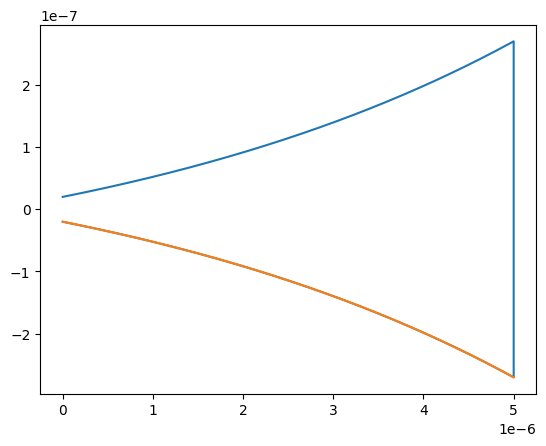

In [ ]:
# Using 0.04μm width and 200μm lenght
mode.deleteall()

width = 0.04e-6
lenght = 5e-6
N = 2000

x = np.linspace(0,lenght,N)
z = (x-x[0])/(x[int(N/2-1)]-x[0])/2
function = ((np.exp(z) - 1)/(np.exp(1) - 1)*1e-6)/4 + width/2
inversefunction = np.flip(function)

X, Y, xinvertido, yinvertido = functionstapers(lenght, N, width, function)
mode.set({
    'z min'    : 0,
    'z max'    : height,
    'x'        : 0,
    'y'        : 0,
    'material' : core,
    'name'     : 'core',
})


# Quadratic

In [ ]:
mode = lumapi.MODE(filename='../CML/Quadratic.lms')

In [7]:
# Using 0.04μm width and 200μm lenght
fdtd.deleteall()

width = 0.04e-6
lenght = 5e-6
N = 2000

x = np.linspace(0,lenght,N)
z = (x-x[0])/(x[int(N/2-1)]-x[0])/2
function = (z**2/4)*1e-6 + width/2
inversefunction = np.flip(function)

X, Y, xinvertido, yinvertido = functionstapers(lenght, N, width, function)

fdtd.set({
    'z min'    : 0,
    'z max'    : height,
    'x'        : 0,
    'y'        : 0,
    'material' : core,
    'name'     : 'core',
})


NameError: name 'fdtd' is not defined